In [173]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plots.style.use('fivethirtyeight')

In [143]:
# Write a function to order months in sequential order, sort table on new variable
def get_month_as_num(month):
    if month == "Jan":
        return 1
    elif month == "Feb":
        return 2
    elif month == "Mar":
        return 3
    elif month == "Apr":
        return 4
    elif month == "May":
        return 5
    else:
        return 0

# Data Exploration: Hypothesis Testing

In [110]:
# Load the data
new_voters_original = Table.read_table("new-voter-registrations.csv")
new_voters_original.show(5)

Jurisdiction,Year,Month,New registered voters
Arizona,2016,Jan,25852
Arizona,2016,Feb,51155
Arizona,2016,Mar,48614
Arizona,2016,Apr,30668
Arizona,2020,Jan,33229


### Generate table to represent voter registration as two samples

In [141]:
# Compare counts of new voters between 2016 and 2020
# .join() shows months order alphabetically, hard to view trends across time
new_voters_2016 = new_voters_original.where("Year", 2016).relabel("New registered voters", "2016 New Voters").drop("Year")
new_voters_2020 = new_voters_original.where("Year", 2020).relabel("New registered voters", "2020 New Voters").drop("Year")
new_voters = new_voters_2016.join(["Jurisdiction", "Month"], new_voters_2020)
new_voters.show(5)

Jurisdiction,Month,2016 New Voters,2020 New Voters
Arizona,Apr,30668,10249
Arizona,Feb,51155,50853
Arizona,Jan,25852,33229
Arizona,Mar,48614,31872
California,Apr,185478,38970


In [142]:
new_voters = new_voters.with_column("num_month", new_voters.apply(get_month_as_num, "Month"))
new_voters = new_voters.sort("num_month").sort(0).drop("num_month")
new_voters

Jurisdiction,Month,2016 New Voters,2020 New Voters
Arizona,Jan,25852,33229
Arizona,Feb,51155,50853
Arizona,Mar,48614,31872
Arizona,Apr,30668,10249
California,Jan,87574,151595
California,Feb,103377,238281
California,Mar,174278,176810
California,Apr,185478,38970
Colorado,Jan,17024,20260
Colorado,Feb,20707,33374


### Generate table to represent voter registration as categorical data

In [147]:
new_voters_grouped = new_voters.group("Month", sum)    
new_voters_grouped = new_voters_grouped.with_column("num_month", new_voters_grouped.apply(get_month_as_num, "Month"))
new_voters_grouped = new_voters_grouped.sort("num_month").drop("num_month")
tvd_tbl = new_voters_grouped.select("Month").\
            with_columns("2016 Distribution", new_voters_grouped.column(2)/sum(new_voters_grouped.column(2)),
                         "2020 Distribution", new_voters_grouped.column(3)/sum(new_voters_grouped.column(3)))

tvd_tbl

Month,2016 Distribution,2020 Distribution
Jan,0.171847,0.282518
Feb,0.255664,0.338101
Mar,0.269627,0.254904
Apr,0.245353,0.0851027
May,0.0575093,0.0393746


### Conduct hypothesis test using TVD as a test statistic

In [149]:
def tvd(dist1, dist2):
    return sum(abs(dist1 - dist2))/2

obs_tvd = tvd(tvd_tbl.column("2016 Distribution"), tvd_tbl.column("2020 Distribution"))
obs_tvd

0.1931079252193249

In [167]:
null_model = tvd_tbl.column("2016 Distribution")
sample_size = sum(new_voters_original.where("Year", 2020).column("New registered voters"))

sample_proportions(sample_size, null_model)

array([0.17205524, 0.25566476, 0.26929215, 0.24574086, 0.057247  ])

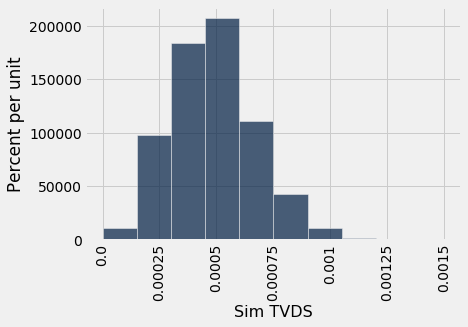

In [194]:
tvds = make_array()

for i in np.arange(1000):
    simulated_dist = sample_proportions(sample_size, null_model)
    simulated_tvd = tvd(simulated_dist, null_model)
    tvds = np.append(tvds, simulated_tvd)
    
Table().with_column("Sim TVDS", tvds).hist(bins = np.arange(0, 0.0015, 0.00015))
#plt.scatter(obs_tvd, 0, color='red', s=30); # plot the observed test statistic